In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="157P9NURpyFItyUyBJpb")
project = rf.workspace("david-lee-d0rhs").project("american-sign-language-letters")
version = project.version(2)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to American-Sign-Language-Letters-2 in yolov8:: 100%|██████████| 10524/10524 [00:03<00:00, 3102.95it/s]


# Load Images


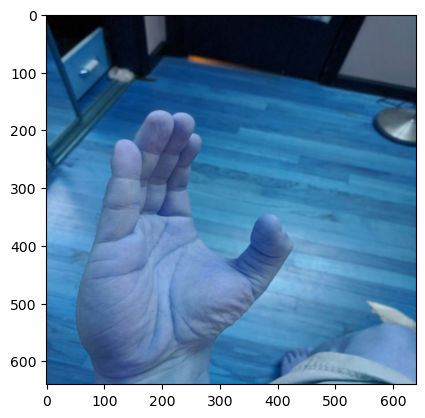

In [3]:
import cv2
from matplotlib import pyplot as plt


image = cv2.imread('American-Sign-Language-Letters-2/test/images/C19_jpg.rf.152461c297bf3ab2284b94d1c32bfe6e.jpg')

plt.imshow(image)

In [5]:
image.shape


(640, 640, 3)

In [6]:
import numpy as np


load_bboxes = np.genfromtxt('American-Sign-Language-Letters-2/test/labels/C19_jpg.rf.152461c297bf3ab2284b94d1c32bfe6e.txt')
load_bboxes = list(load_bboxes)
bbox_cat = int(load_bboxes[0])
bboxes = load_bboxes[1:]
bboxes


[0.37109375, 0.61328125, 0.609375, 0.7359375]

In [7]:
bbox_cat


2

In [8]:
load_bboxes


[2.0, 0.37109375, 0.61328125, 0.609375, 0.7359375]

In [9]:
# Image info
img_ht = int(image.shape[0])
img_wd = int(image.shape[1])
bb_width = int(round(bboxes[2] * image.shape[1], 0))
bb_height = int(round(bboxes[3] * image.shape[0], 0))

print(f'Image height: {img_ht}')
print(f'Image width: {img_wd}')
print(f'Bbox height: {bb_height}')
print(f'Bbox width: {bb_width}')


Image height: 640
Image width: 640
Bbox height: 471
Bbox width: 390


In [10]:
# pascal_voc format 
x_min = int((img_wd * bboxes[0]) - (bb_width/2))
x_max = int((img_wd * bboxes[0]) + (bb_width/2))
y_min = int(img_ht * bboxes[1] - (bb_height/2))
y_max = int(img_ht * bboxes[1] + (bb_height/2))
new_bboxes = [x_min, y_min, x_max, y_max]
print(f'Bbox x_min: {x_min}')
print(f'Bbox x_max: {x_max}')
print(f'Bbox y_min: {y_min}')
print(f'Bbox y_max: {y_max}')
print(f'new_bboxes: {new_bboxes}')


Bbox x_min: 42
Bbox x_max: 432
Bbox y_min: 157
Bbox y_max: 628
new_bboxes: [42, 157, 432, 628]


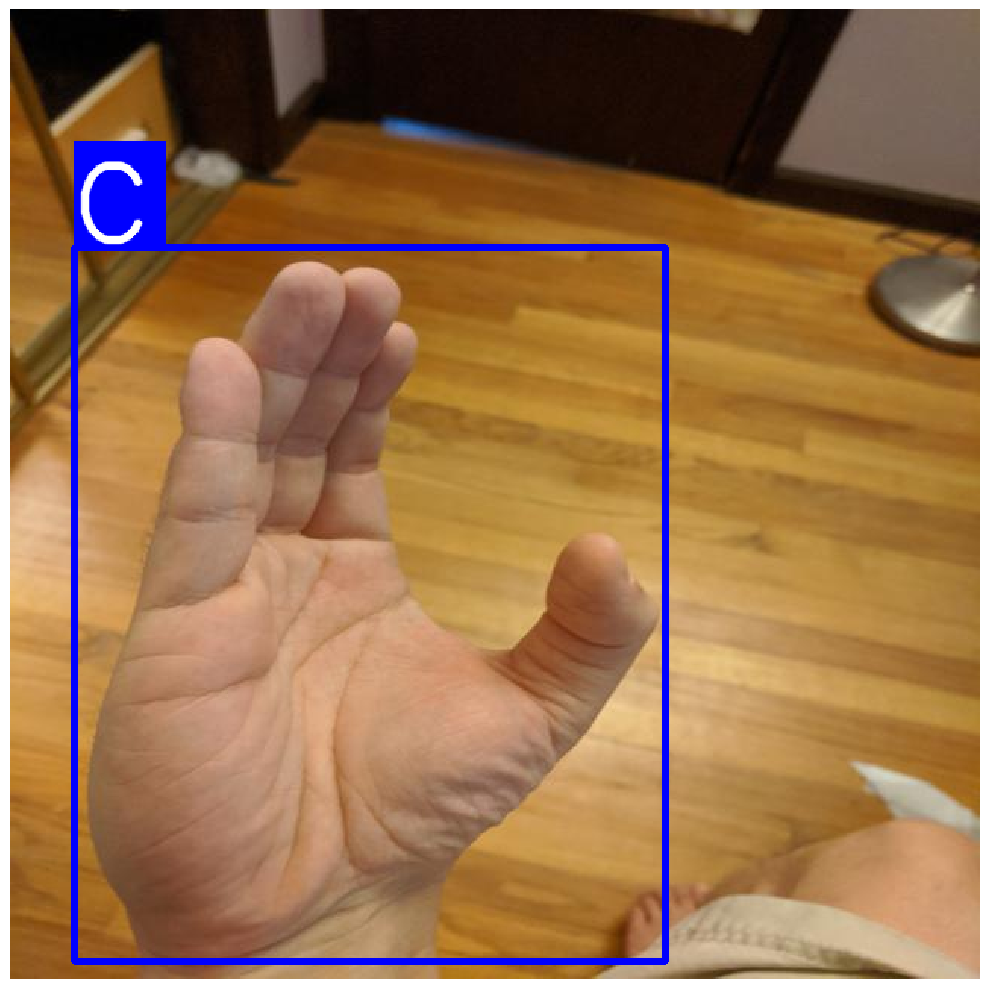

In [11]:
# Show image and Bounding Box Function
# Inspired by Venelin Valkov
# Source: https://www.curiousily.com/posts/image-data-augmentation-for-tensorflow-2-keras-and-pytorch-with-albumentations-in-python/
category_id_to_name = {0: 'A', 
                       1: 'B',
                       2: 'C', 
                       3: 'D',
                       4: 'E', 
                       5: 'F',
                       6: 'G', 
                       7: 'H',
                       8: 'I', 
                       9: 'J',
                       10: 'K',
                       11: 'L',
                       12: 'M',
                       13: 'N',
                       14: 'O',
                       15: 'P',
                       16: 'Q',
                       17: 'R',
                       18: 'S',
                       19: 'T',
                       20: 'U',
                       21: 'V',
                       22: 'W',
                       23: 'X',
                       24: 'Y',
                       25: 'Z',
                       }
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255) # White

def show_image(image, bbox, bbox_cat, category_id_to_name):
    class_name = category_id_to_name[bbox_cat]
    image = visualize_bbox(image.copy(), bbox, class_name)
    f = plt.figure(figsize=(10,10))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()
    
def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=4):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(
        image,
        (x_min, y_min),
        (x_max, y_max),
        color=color,
        thickness=thickness
    )
        
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 2.7, 3)    
    cv2.rectangle(image, (x_min, y_min - int(1.2 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        image,
        text= category_id_to_name[bbox_cat],
        org=(x_min, y_min - int(.1 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.35, 
        color=TEXT_COLOR,
        thickness=3,
        lineType=cv2.LINE_AA,
    )
    return image


show_image(image, new_bboxes, bbox_cat, category_id_to_name)

In [1]:
import cv2
import mediapipe as mp
import os

# Set up MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Input and output directories
input_folder = "American-Sign-Language-Letters-2/train/images"
output_folder = "Processed-ASL-Dataset/train/images"
os.makedirs(output_folder, exist_ok=True)

# Iterate over the images in the folder and draw landmarks
for img_file in os.listdir(input_folder):
    img_path = os.path.join(input_folder, img_file)
    image = cv2.imread(img_path)
    
    # Convert the image to RGB because MediaPipe requires RGB images
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image to detect hand landmarks
    results = hands.process(image_rgb)
    
    # If hands are detected, draw the landmarks on the image
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
    # Save the image with landmarks drawn
    output_path = os.path.join(output_folder, img_file)
    cv2.imwrite(output_path, image)

# Close MediaPipe when done
hands.close()


In [2]:
import os
import shutil

# Define the input and output folders
input_label_folder = "American-Sign-Language-Letters-2/train/labels"  # Original folder with labels
output_label_folder = "Processed-ASL-Dataset/train/labels"  # New folder for processed labels

# Create the output folder if it doesn't exist
os.makedirs(output_label_folder, exist_ok=True)

# Iterate over all label files in the original folder and copy them to the new folder
for label_file in os.listdir(input_label_folder):
    label_path = os.path.join(input_label_folder, label_file)
    
    # Check if it's a .txt file
    if label_file.endswith('.txt'):
        # Create the destination path
        destination_path = os.path.join(output_label_folder, label_file)
        
        # Copy the label file
        shutil.copy(label_path, destination_path)

print("Label files copied successfully.")


Label files copied successfully.


In [4]:
import cv2
import mediapipe as mp
import os

# Set up MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Input and output directories
input_folder = "American-Sign-Language-Letters-2/test/images"
output_folder = "Processed-ASL-Dataset/test/images"
os.makedirs(output_folder, exist_ok=True)

# Iterate over the images in the folder and draw landmarks
for img_file in os.listdir(input_folder):
    img_path = os.path.join(input_folder, img_file)
    image = cv2.imread(img_path)
    
    # Convert the image to RGB because MediaPipe requires RGB images
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image to detect hand landmarks
    results = hands.process(image_rgb)
    
    # If hands are detected, draw the landmarks on the image
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
    # Save the image with landmarks drawn
    output_path = os.path.join(output_folder, img_file)
    cv2.imwrite(output_path, image)

# Close MediaPipe when done
hands.close()


In [3]:
import os
import shutil

# Define the input and output folders
input_label_folder = "American-Sign-Language-Letters-2/test/labels"  # Original folder with labels
output_label_folder = "Processed-ASL-Dataset/test/labels"  # New folder for processed labels

# Create the output folder if it doesn't exist
os.makedirs(output_label_folder, exist_ok=True)

# Iterate over all label files in the original folder and copy them to the new folder
for label_file in os.listdir(input_label_folder):
    label_path = os.path.join(input_label_folder, label_file)
    
    # Check if it's a .txt file
    if label_file.endswith('.txt'):
        # Create the destination path
        destination_path = os.path.join(output_label_folder, label_file)
        
        # Copy the label file
        shutil.copy(label_path, destination_path)

print("Label files copied successfully.")


Label files copied successfully.


In [5]:
import cv2
import mediapipe as mp
import os

# Set up MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Input and output directories
input_folder = "American-Sign-Language-Letters-2/valid/images"
output_folder = "Processed-ASL-Dataset/valid/images"
os.makedirs(output_folder, exist_ok=True)

# Iterate over the images in the folder and draw landmarks
for img_file in os.listdir(input_folder):
    img_path = os.path.join(input_folder, img_file)
    image = cv2.imread(img_path)
    
    # Convert the image to RGB because MediaPipe requires RGB images
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image to detect hand landmarks
    results = hands.process(image_rgb)
    
    # If hands are detected, draw the landmarks on the image
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
    # Save the image with landmarks drawn
    output_path = os.path.join(output_folder, img_file)
    cv2.imwrite(output_path, image)

# Close MediaPipe when done
hands.close()


In [6]:
import os
import shutil

# Define the input and output folders
input_label_folder = "American-Sign-Language-Letters-2/valid/labels"  # Original folder with labels
output_label_folder = "Processed-ASL-Dataset/valid/labels"  # New folder for processed labels

# Create the output folder if it doesn't exist
os.makedirs(output_label_folder, exist_ok=True)

# Iterate over all label files in the original folder and copy them to the new folder
for label_file in os.listdir(input_label_folder):
    label_path = os.path.join(input_label_folder, label_file)
    
    # Check if it's a .txt file
    if label_file.endswith('.txt'):
        # Create the destination path
        destination_path = os.path.join(output_label_folder, label_file)
        
        # Copy the label file
        shutil.copy(label_path, destination_path)

print("Label files copied successfully.")


Label files copied successfully.


In [1]:
from ultralytics import YOLO

# Load the YOLOv8 model (pretrained weights)
model = YOLO("yolov8n.pt")  # 'n' stands for Nano model; you can also try 's', 'm', 'l', 'x'

# Train the model
model.train(
    data="Processed-ASL-Dataset/data.yaml",    # Path to your data.yaml
    epochs=30,          # Number of training epochs
    imgsz=640,           # Image size
    batch=16,            # Batch size
    device=0,             # Use GPU (0 = first GPU; 'cpu' for CPU)
    project=".",               # Save in the current working directory
    name="asl_training",       # Folder name where results will be stored
)


New https://pypi.org/project/ultralytics/8.3.49 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.31  Python-3.12.1 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Processed-ASL-Dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=., name=asl_training, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=No

train: Scanning C:\Users\ACER\final_AI_test_v2\Processed-ASL-Dataset\train\labels... 5040 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5040/5040 [00:10<00:00, 498.40it/s]


train: New cache created: C:\Users\ACER\final_AI_test_v2\Processed-ASL-Dataset\train\labels.cache


val: Scanning C:\Users\ACER\final_AI_test_v2\Processed-ASL-Dataset\valid\labels... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<00:00, 320.71it/s]

val: New cache created: C:\Users\ACER\final_AI_test_v2\Processed-ASL-Dataset\valid\labels.cache


Plotting labels to asl_training\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to asl_training
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.52G      1.079      3.859      1.546         43        640: 100%|██████████| 315/315 [00:46<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        144        144      0.374      0.433      0.401      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.38G     0.9588      2.739      1.407         35        640: 100%|██████████| 315/315 [00:43<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]

                   all        144        144      0.615      0.682      0.703      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.38G     0.9239      2.208      1.357         33        640: 100%|██████████| 315/315 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]

                   all        144        144      0.757      0.756       0.87      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.38G      0.893      1.866      1.317         36        640: 100%|██████████| 315/315 [00:43<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

                   all        144        144      0.761      0.792      0.882       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.38G     0.8573      1.638      1.292         37        640: 100%|██████████| 315/315 [00:45<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        144        144      0.824      0.827      0.912      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.38G     0.8369      1.488      1.268         38        640: 100%|██████████| 315/315 [00:47<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

                   all        144        144       0.84      0.861      0.938      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.38G     0.8061      1.351      1.243         34        640: 100%|██████████| 315/315 [00:46<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

                   all        144        144      0.856      0.883      0.944      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.38G     0.7949      1.267      1.231         37        640: 100%|██████████| 315/315 [00:46<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

                   all        144        144       0.87       0.87      0.924      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.38G     0.7781      1.189      1.224         43        640: 100%|██████████| 315/315 [00:46<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]

                   all        144        144      0.912      0.882      0.952      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.38G     0.7708      1.141      1.214         34        640: 100%|██████████| 315/315 [00:46<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]

                   all        144        144      0.896      0.881      0.937      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.38G     0.7395      1.072      1.198         38        640: 100%|██████████| 315/315 [00:46<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]

                   all        144        144      0.914      0.858      0.936      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.38G     0.7403      1.037      1.195         35        640: 100%|██████████| 315/315 [00:46<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]

                   all        144        144      0.953      0.875      0.952      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.38G     0.7224     0.9785      1.184         31        640: 100%|██████████| 315/315 [00:55<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all        144        144       0.93      0.871      0.955      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.38G     0.7071     0.9315      1.173         32        640: 100%|██████████| 315/315 [01:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        144        144      0.927      0.881      0.951      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.38G     0.7018     0.9099      1.169         30        640: 100%|██████████| 315/315 [01:57<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        144        144      0.905       0.86      0.945      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.38G     0.6991      0.882      1.166         41        640: 100%|██████████| 315/315 [01:56<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        144        144      0.888       0.88      0.947      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.38G     0.6907     0.8648      1.159         35        640: 100%|██████████| 315/315 [01:45<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


                   all        144        144      0.933      0.858      0.946      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.38G     0.6734     0.8236      1.149         35        640: 100%|██████████| 315/315 [00:57<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]

                   all        144        144      0.873      0.862      0.923      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.38G     0.6765      0.811      1.153         45        640: 100%|██████████| 315/315 [00:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        144        144       0.93      0.869      0.954      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.38G     0.6572     0.7776       1.14         44        640: 100%|██████████| 315/315 [00:57<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        144        144      0.916      0.873      0.943      0.672


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.47G     0.5215     0.4526      1.112         16        640: 100%|██████████| 315/315 [00:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


                   all        144        144      0.916      0.871      0.946      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.38G     0.4966      0.411      1.089         16        640: 100%|██████████| 315/315 [00:56<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

                   all        144        144       0.96      0.877      0.955      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.38G     0.4957     0.3954      1.091         16        640: 100%|██████████| 315/315 [00:55<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

                   all        144        144      0.951      0.882      0.952      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.38G     0.4731      0.369      1.066         16        640: 100%|██████████| 315/315 [01:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

                   all        144        144      0.933      0.881      0.944      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.38G     0.4638     0.3606      1.065         16        640: 100%|██████████| 315/315 [01:45<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


                   all        144        144      0.936      0.871      0.955      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.38G     0.4515     0.3451      1.055         16        640: 100%|██████████| 315/315 [02:14<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        144        144       0.91      0.893      0.952      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.38G     0.4419     0.3313       1.04         16        640: 100%|██████████| 315/315 [02:11<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        144        144      0.941      0.876      0.953      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.38G     0.4281     0.3209      1.032         16        640: 100%|██████████| 315/315 [01:21<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


                   all        144        144      0.938      0.878      0.955      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.38G     0.4199     0.3156      1.026         16        640: 100%|██████████| 315/315 [00:59<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


                   all        144        144      0.949      0.882      0.956      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.38G     0.4151     0.3096      1.027         16        640: 100%|██████████| 315/315 [01:33<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        144        144       0.94      0.889      0.955      0.768



30 epochs completed in 0.606 hours.
Optimizer stripped from asl_training\weights\last.pt, 6.3MB
Optimizer stripped from asl_training\weights\best.pt, 6.3MB

Validating asl_training\weights\best.pt...
Ultralytics 8.3.31  Python-3.12.1 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 168 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


                   all        144        144      0.947      0.884      0.955      0.769
                     A          5          5      0.972        0.8      0.886      0.678
                     B          9          9          1      0.711      0.995      0.834
                     C          3          3      0.956          1      0.995      0.895
                     D          6          6      0.958      0.833      0.972      0.813
                     E          4          4      0.948          1      0.995      0.895
                     F          8          8      0.973          1      0.995       0.85
                     G          5          5       0.96          1      0.995      0.779
                     H          9          9      0.999          1      0.995      0.697
                     I          2          2      0.878        0.5        0.5        0.4
                     J          8          8      0.985          1      0.995      0.626
                     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018D51067110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [2]:
# Evaluate the model on validation data
metrics = model.val()
print(metrics)  # This will print mAP, precision, recall, etc.


Ultralytics 8.3.31  Python-3.12.1 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 168 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\ACER\final_AI_test_v2\Processed-ASL-Dataset\valid\labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


                   all        144        144      0.947      0.884      0.955       0.77
                     A          5          5      0.972        0.8      0.886      0.678
                     B          9          9          1      0.716      0.995      0.834
                     C          3          3      0.955          1      0.995      0.895
                     D          6          6      0.958      0.833      0.972      0.813
                     E          4          4      0.948          1      0.995      0.895
                     F          8          8      0.973          1      0.995      0.848
                     G          5          5       0.96          1      0.995      0.779
                     H          9          9      0.999          1      0.995        0.7
                     I          2          2      0.879        0.5        0.5        0.4
                     J          8          8      0.984          1      0.995      0.626
                     

In [3]:
model.save('mediapipe_asl_model.pt')

In [1]:
from ultralytics import YOLO

model = YOLO("mediapipe_asl_model.pt")

model.train(
    data="Processed-ASL-Dataset/data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    lr0=0.01,        # Initial learning rate
    optimizer="Adam",  # Optimizer,
    project=".",               # Save in the current working directory
    name="asl_tuning",       # Folder name where results will be stored
    device=0,   
)


New https://pypi.org/project/ultralytics/8.3.49 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.31  Python-3.12.1 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=mediapipe_asl_model.pt, data=Processed-ASL-Dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=., name=asl_tuning2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

train: Scanning C:\Users\ACER\final_AI_test_v2\Processed-ASL-Dataset\train\labels.cache... 5040 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5040/5040 [00:00<?, ?it/s]
val: Scanning C:\Users\ACER\final_AI_test_v2\Processed-ASL-Dataset\valid\labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]


Plotting labels to asl_tuning2\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to asl_tuning2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       2.4G      1.141      1.768      1.483         43        640: 100%|██████████| 315/315 [12:15<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        144        144      0.625      0.452       0.53      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.37G      1.165      1.952      1.496         35        640: 100%|██████████| 315/315 [00:46<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]

                   all        144        144      0.579      0.595      0.706      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.37G      1.146      1.919      1.479         33        640: 100%|██████████| 315/315 [00:44<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]

                   all        144        144      0.666      0.487      0.582      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.37G      1.116      1.821      1.448         36        640: 100%|██████████| 315/315 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]

                   all        144        144      0.751      0.706      0.824      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.37G      1.055      1.665      1.409         37        640: 100%|██████████| 315/315 [00:42<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]

                   all        144        144       0.72      0.745      0.857      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.37G      1.024      1.522      1.376         38        640: 100%|██████████| 315/315 [00:42<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.05it/s]

                   all        144        144      0.615      0.826      0.841      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.37G     0.9862      1.442      1.346         34        640: 100%|██████████| 315/315 [00:42<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]

                   all        144        144      0.743       0.84      0.879      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.37G     0.9754      1.394      1.335         37        640: 100%|██████████| 315/315 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

                   all        144        144      0.786       0.82      0.882      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.37G     0.9598       1.31      1.328         43        640: 100%|██████████| 315/315 [00:42<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]

                   all        144        144       0.84      0.801      0.913       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.37G     0.9447      1.272      1.314         34        640: 100%|██████████| 315/315 [00:42<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]

                   all        144        144      0.712      0.857      0.889      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.37G     0.9236      1.243      1.305         38        640: 100%|██████████| 315/315 [00:42<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]

                   all        144        144      0.849      0.813      0.903      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.37G     0.9137      1.218      1.297         35        640: 100%|██████████| 315/315 [00:42<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]

                   all        144        144      0.851      0.865      0.915      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.37G     0.8945      1.159      1.284         31        640: 100%|██████████| 315/315 [00:42<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]

                   all        144        144      0.884      0.884      0.947      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.37G     0.8684      1.104      1.268         32        640: 100%|██████████| 315/315 [00:42<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

                   all        144        144      0.879      0.838       0.94       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.37G     0.8592      1.091      1.261         30        640: 100%|██████████| 315/315 [00:42<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        144        144      0.853      0.874      0.918      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.37G     0.8612      1.067       1.26         41        640: 100%|██████████| 315/315 [00:42<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]

                   all        144        144      0.865      0.849      0.914      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.37G     0.8414      1.022      1.242         35        640: 100%|██████████| 315/315 [00:42<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]

                   all        144        144      0.884      0.862      0.936       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.37G     0.8202     0.9772      1.227         35        640: 100%|██████████| 315/315 [00:42<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

                   all        144        144      0.846      0.839      0.918      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.37G      0.813     0.9552      1.229         45        640: 100%|██████████| 315/315 [00:42<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]

                   all        144        144      0.886      0.841      0.944      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.37G     0.7928     0.9216      1.215         44        640: 100%|██████████| 315/315 [00:42<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]

                   all        144        144      0.914      0.855      0.939      0.629


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.47G     0.6344     0.4693      1.205         16        640: 100%|██████████| 315/315 [00:43<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]

                   all        144        144      0.914      0.882      0.946      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.37G     0.6096     0.4217      1.181         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.97it/s]

                   all        144        144      0.897      0.857       0.94      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.37G      0.593     0.3986      1.168         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

                   all        144        144      0.918      0.872       0.95       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.37G     0.5703     0.3669      1.143         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

                   all        144        144      0.912      0.871      0.941      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.37G     0.5593     0.3513      1.139         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]

                   all        144        144      0.926      0.892      0.955      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.37G     0.5384     0.3288       1.12         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

                   all        144        144      0.925      0.864      0.955       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.37G     0.5248      0.307      1.103         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

                   all        144        144       0.93      0.896       0.96      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.37G     0.4992     0.2898      1.085         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]

                   all        144        144      0.923      0.895      0.955      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.37G      0.482     0.2734      1.074         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.19it/s]

                   all        144        144      0.925      0.909      0.964      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.37G      0.469     0.2594      1.067         16        640: 100%|██████████| 315/315 [00:42<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.03it/s]

                   all        144        144       0.92      0.922      0.964      0.766



30 epochs completed in 0.581 hours.
Optimizer stripped from asl_tuning2\weights\last.pt, 6.3MB
Optimizer stripped from asl_tuning2\weights\best.pt, 6.3MB

Validating asl_tuning2\weights\best.pt...
Ultralytics 8.3.31  Python-3.12.1 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 168 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


                   all        144        144       0.92      0.922      0.964      0.766
                     A          5          5          1      0.844      0.995      0.763
                     B          9          9      0.993          1      0.995      0.824
                     C          3          3          1      0.837      0.995      0.801
                     D          6          6      0.846      0.924      0.972      0.796
                     E          4          4      0.785          1      0.995      0.854
                     F          8          8      0.966          1      0.995      0.829
                     G          5          5      0.954          1      0.995       0.82
                     H          9          9      0.982          1      0.995      0.696
                     I          2          2      0.868        0.5      0.662      0.565
                     J          8          8      0.958          1      0.995      0.677
                     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024C50396E10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [2]:
model.save('mediapipe_tuning_asl_model.pt')